In [165]:
# all imports here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [117]:
# read the files

# genes information file 
genes = pd.read_csv('ensembl_genes.txt', sep='\t')

# atacseq bed file (ENCFF994UIF)
column_names = ['chr', 'start', 'end', 'peak_id', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak']
peaks = pd.read_csv('adrenal_gland/ATACseq/processed_data/ENCFF994UIF.bed', sep='\t', header=None, names=column_names)


In [172]:
# rnaseq expression levels (ENCFF000VWO)
exp = pd.read_csv('adrenal_gland/RNAseq/processed_data/ENCFF743UBV.tsv', sep='\t', usecols=['gene_id', 'TPM'])

In [118]:
# first filter genes to only have the genes which are also in the rnaseq expression file
# and also reset the index 
genes = genes[genes['Gene stable ID version'].isin(exp['gene_id'])].reset_index(drop=True)
# also add string chr before every chromosome number 
genes['Chromosome/scaffold name'] = 'chr' + genes['Chromosome/scaffold name'].astype(str)

In [119]:
# make a new column in genes, which is the mid point of the gene, rounded off to the nearest integer
genes['mid'] = (genes['Gene start (bp)'] + genes['Gene end (bp)'])/2
genes['mid'] = genes['mid'].round(0).astype(int)

In [120]:
# make a new column in peaks, which is the mid point of the peak, rounded off to the nearest integer
peaks['mid'] = (peaks['start'] + peaks['end'])/2
peaks['mid'] = peaks['mid'].round(0).astype(int)

In [121]:
# also in peaks, if two rows have the same mid point, then keep the row with the higher score
peaks = peaks.sort_values('score', ascending=False).drop_duplicates('mid').sort_index()
# reset the index
peaks = peaks.reset_index(drop=True)

In [122]:
# 45 mins expected time for this loop

# now loop through the peaks and find the nearest gene (using midpoint of gene and peak) for each peak and store that 
# in a new column in peaks
peaks['nearest_gene'] = ''
peaks['distance'] = ''
for index, row in peaks.iterrows():
    # first store the subset of genes which are on the same chromosome as the peak
    genes_subset = genes[genes['Chromosome/scaffold name'] == row['chr']]
    # now find the nearest gene (using midpoint of gene and peak) for each peak and store that
    # in a new column in peaks
    peaks.loc[index, 'nearest_gene'] = genes_subset.iloc[(genes_subset['mid']-row['mid']).abs().argsort()[:1]]['Gene stable ID version'].values[0]
    # now also store the distance of the peak from the gene
    peaks.loc[index, 'distance'] = (genes_subset.iloc[(genes_subset['mid']-row['mid']).abs().argsort()[:1]]['mid'].values[0] - row['mid'])

    # break the loop after 1000 peaks
    # if index == 1000:
    #    break

# save the peaks file for later use
peaks.to_csv('peaks.csv', index=False)

In [179]:
# in peaks dataframe, groupby the nearest gene and make a new column which is the mean of the 
# score column for each gene
peaks['mean_score'] = peaks.groupby('nearest_gene')['score'].transform('mean')

In [184]:
# now make a new df containing only the genes in nearest_gene column of peaks, their mean score and 
# their expression level
genes_with_peaks = pd.DataFrame()
genes_with_peaks['gene_id'] = peaks['nearest_gene'].unique()
# now for each gene, find the mean score and expression level from peaks and exp dataframes respectively
genes_with_peaks['mean_score'] = genes_with_peaks['gene_id'].map(peaks.groupby('nearest_gene')['score'].mean())
genes_with_peaks['TPM'] = genes_with_peaks['gene_id'].map(exp.groupby('gene_id')['TPM'].mean())

In [185]:
# make another column in genes_with_peaks which is the 1+log of the TPM
genes_with_peaks['log_TPM'] = np.log(genes_with_peaks['TPM']+1)
# also remove the genes with TPM = 0
genes_with_peaks = genes_with_peaks[genes_with_peaks['TPM'] != 0].reset_index(drop=True)
# also remove the gene with TPM in the top 1 percentile
genes_with_peaks = genes_with_peaks[genes_with_peaks['TPM'] < genes_with_peaks['TPM'].quantile(0.99)].reset_index(drop=True)
# also remove the gene with TPM < 0.1
genes_with_peaks = genes_with_peaks[genes_with_peaks['TPM'] > 0.1].reset_index(drop=True)

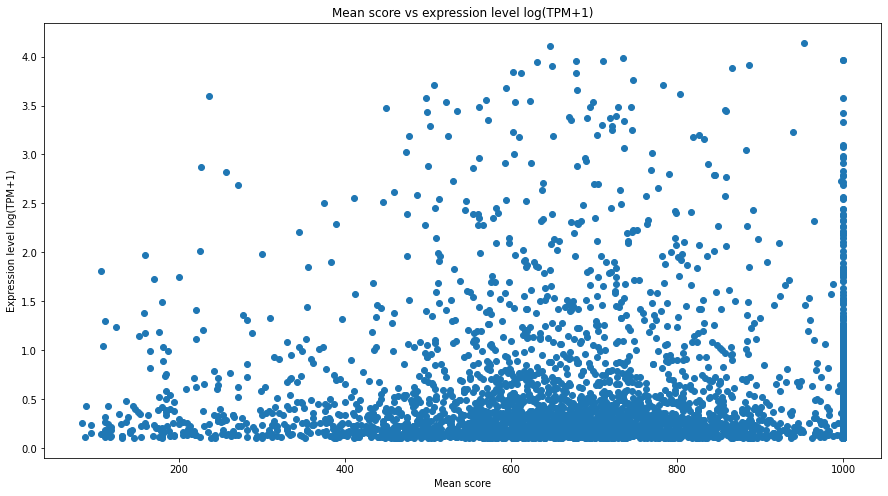

In [186]:
# make a scatter plot of mean score vs expression level
plt.figure(figsize=(15, 8))  # Increase the size of the plot by specifying figsize
plt.scatter(genes_with_peaks['mean_score'], genes_with_peaks['log_TPM'])
plt.xlabel('Mean score')
plt.ylabel('Expression level log(TPM+1)')
plt.title('Mean score vs expression level log(TPM+1)')
plt.show()

In [188]:
# some statistics on the correlation between mean score and expression level
print('Spearman correlation between mean score and expression level log(TPM+1): ', genes_with_peaks['mean_score'].corr(genes_with_peaks['TPM'], method='spearman'))
print('Pearson correlation between mean score and expression level log(TPM+1): ', genes_with_peaks['mean_score'].corr(genes_with_peaks['TPM'], method='pearson'))
# p-value for the correlation
print('p-value for the correlation between mean score and expression level log(TPM+1): ', stats.pearsonr(genes_with_peaks['mean_score'], genes_with_peaks['log_TPM'])[1])

Spearman correlation between mean score and expression level log(TPM+1):  0.03515533660257652
Pearson correlation between mean score and expression level log(TPM+1):  0.021594082673243593
p-value for the correlation between mean score and expression level log(TPM+1):  0.04269644299370743


In [157]:
# now merge the peaks and rnaseq expression file on the nearest gene column
# first rename the gene_id column in exp to nearest_gene
exp = exp.rename(columns={'gene_id': 'nearest_gene'})
# now merge the two files
merged = pd.merge(peaks, exp, on='nearest_gene', how='left')

In [158]:
# make another column in merged, which is the log of the expression level
merged['log_TPM'] = merged['TPM'].apply(lambda x: np.log2(x+1))

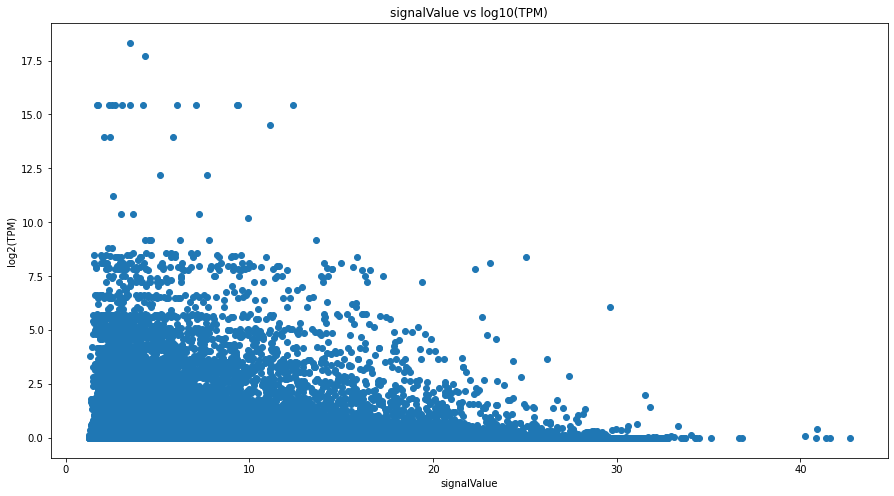

In [160]:
# make a plot of the signalValue vs the TPM, with TPM plotted as log2(TPM)
plt.figure(figsize=(15, 8))  # Increase the size of the plot by specifying figsize
plt.scatter(merged['signalValue'], merged['log_TPM'])
plt.xlabel('signalValue')
plt.ylabel('log2(TPM)')
plt.title('signalValue vs log10(TPM)')
plt.show()

In [168]:
# some statistics on the correlation between signalValue and expression level
print('Spearman correlation between signalValue and expression level log2(TPM): ', merged['signalValue'].corr(merged['log_TPM'], method='spearman'))
print('Pearson correlation between signalValue and expression level log2(TPM): ', merged['signalValue'].corr(merged['log_TPM'], method='pearson'))
# pvalue of the correlation
print('pvalue of the correlation between signalValue and expression level log2(TPM): ', stats.pearsonr(merged['signalValue'], merged['log_TPM'])[1])

Spearman correlation between signalValue and expression level log2(TPM):  -0.03765471961001373
Pearson correlation between signalValue and expression level log2(TPM):  -0.021271878107570728
pvalue of the correlation between signalValue and expression level log2(TPM):  2.05520479624125e-18


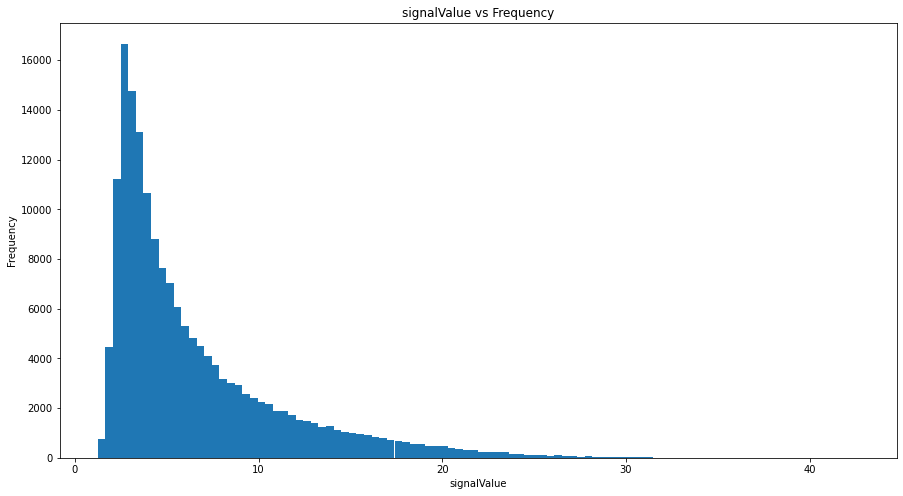

In [161]:
# make a histogram of the signalValue vs the frequency
plt.figure(figsize=(15, 8))  # Increase the size of the plot by specifying figsize
plt.hist(merged['signalValue'], bins=100)
plt.xlabel('signalValue')
plt.ylabel('Frequency')
plt.title('signalValue vs Frequency')
plt.show()

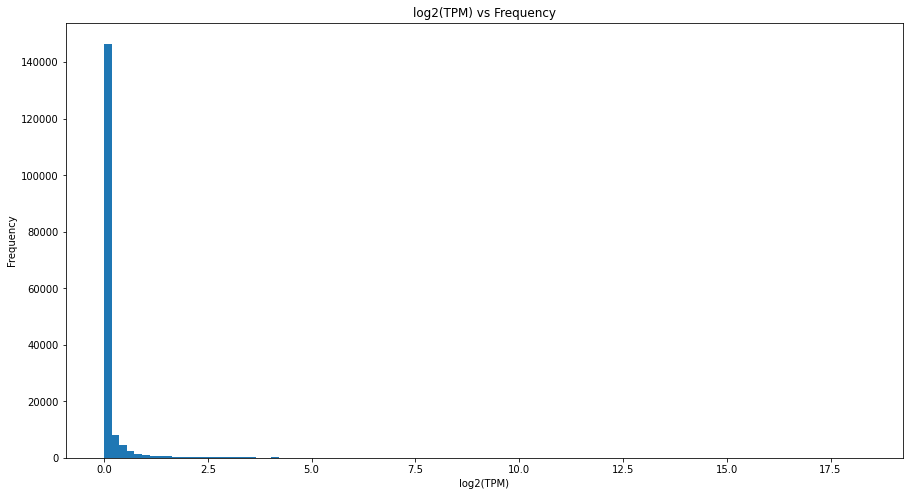

In [162]:
# make a histogram of the log_TPM vs the frequency
plt.figure(figsize=(15, 8))  # Increase the size of the plot by specifying figsize
plt.hist(merged['log_TPM'], bins=100)
plt.xlabel('log2(TPM)')
plt.ylabel('Frequency')
plt.title('log2(TPM) vs Frequency')
plt.show()

In [ ]:
# already tried
# 1. all the genes in the genes df are in the rnaseq expression file, so no need to filter them out

# what all can be done
# 1. the peaks whose nearest gene is very far away, can be removed
# 2. can make the plot in a better way, by showing the genes on the x axis and avg of signalValue of all 
#   the peaks which are nearest to that gene on the y axis